Import the neccessary libraries

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import warnings

In [21]:
warnings.filterwarnings("ignore") # To supress warnings

In [22]:
# Set the global plotting style for better aesthetics
plt.style.use("fivethirtyeight")

Data Loading and Acquitsion

In [23]:
ticker = "NVDA"

In [24]:
def load_data(ticker="NVDA",start_date="2023-01-01",end_date=pd.to_datetime("today").strftime('%Y-%m-%d')):
    print(f"Loading data for {ticker}......")
    # Download historical stock data from the Yahoo Finance
    df = yf.download(ticker,start=start_date,end=end_date)
    # Target Variable: The prce we want to predict (Next Day's Close Price)
    # We shift the "Close" column up by -1 day (the future day)
    df["Target"] = df["Close"].shift(-1)
    # Feature Enginneering: Lagged price Yesterday's Close price is a key predictor for today's price
    df["Lag_1"] = df["Close"].shift(-1)
    # Feature Engineering: Daily Volatility (High-Low)
    df["Volatility"] = df["High"] - df["Low"]
    # Drop rows with NaN nvalues created by shift/lag (the first and last rows)
    df.dropna(inplace=True)

    return df

In [25]:
# Load the NVIDIA data
df = load_data()

Loading data for NVDA......


[*********************100%***********************]  1 of 1 completed


In [26]:
df.reset_index(inplace=True)

In [27]:
# Check if data was successfully loaded and is not empty
if df.empty:
    print(f"No data retrived for {ticker}. Exiting...")
    exit()

In [28]:
df

Price,Date,Close,High,Low,Open,Volume,Target,Lag_1,Volatility
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA,,,
0,2023-01-03,14.301479,14.981837,14.082686,14.836973,401277000,14.735071,14.735071,0.899151
1,2023-01-04,14.735071,14.838973,14.227551,14.553244,431324000,14.251528,14.251528,0.611422
2,2023-01-05,14.251528,14.550245,14.134638,14.477314,389168000,14.844968,14.844968,0.415607
3,2023-01-06,14.844968,14.995825,14.020747,14.460331,405044000,15.613240,15.613240,0.975078
4,2023-01-09,15.613240,16.040836,15.126700,15.269565,504231000,15.893974,15.893974,0.914136
...,...,...,...,...,...,...,...,...,...
696,2025-10-13,188.320007,190.110001,185.960007,187.970001,153482800,180.029999,180.029999,4.149994
697,2025-10-14,180.029999,184.800003,179.699997,184.770004,205641400,179.830002,179.830002,5.100006
698,2025-10-15,179.830002,184.869995,177.289993,184.800003,214450500,181.809998,181.809998,7.580002


Data Preprocessing

In [29]:
# Check for missing values
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
Price       Ticker
Date                  0
Close       NVDA      0
High        NVDA      0
Low         NVDA      0
Open        NVDA      0
Volume      NVDA      0
Target                0
Lag_1                 0
Volatility            0
dtype: int64


In [30]:
# Check for dupliated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


Feature Engineering

In [31]:
# Define the features (X) and target (y)
# Features used for prediction: Today's Close, Yesterday's Close and Today's Volatility
features = ["Close","Lag_1","Volatility"]
X = df[features].values
y = df["Target"].values

Data Splitting

In [32]:
# Split the data into training (80%) and testing (20%) sets
# shuffle=False is cruical for time-series data to maintain temporal order
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

Data Scaling

In [33]:
# Stanadardize features by removing the mean and scaling to unit variance
# This is crucial for distance-based algorithms like SVR and Linear Models with regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the fitted scaler from the training set

Model Definition and Hyperparameter Tuning

In [34]:
# Dictionary to store the best model and its name
best_model = {
    "score":-np.inf,
    "name":None,
    "model":None
}

results = {}

In [35]:
# Linear Regresson (No tuning needed)
print("Training Linear Regression......")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled,y_train)
lr_pred = lr_model.predict(X_test_scaled)
results["Linear Regression"] = {
    "model":lr_model,
    "y_pred":lr_pred
}

Training Linear Regression......


In [36]:
# Ridge Regression (Tuning Alpha)
print("Tuning Ridge Regression.......")
# Define the hyperparameter grid for Ridge (alpha contols regularization strength)
ridge_params = {
    "alpha":np.logspace(-4,2,100)
} # 100 values between 0.0001 and 100
ridge_search = RandomizedSearchCV(Ridge(random_state=42),ridge_params,n_iter=20,cv=5,scoring="neg_mean_squared_error",random_state=42,n_jobs=-1)
ridge_search.fit(X_train_scaled,y_train)
ridge_model = ridge_search.best_estimator_
ridge_pred = ridge_model.predict(X_test_scaled)
results["Ridge Regression"] = {
    "model":ridge_model,
    "y_pred":ridge_pred
}

Tuning Ridge Regression.......


In [37]:
# Support Vector Regression (SVR) (Tuning C and Gamma)
print("Tuning Support Vector Regression (SVR)........")
# Define the hyperparameter grid for SVR (C for penalty, gamma for kernel influence)
svr_params = {
    "C":[0.1,1,10,100],
    "gamma":["scale","auto",0.01,0.1,1],
    "kernel":["rbf"] # Radial Basis Function (RBF) is best for non-linear data
}
svr_search = RandomizedSearchCV(SVR(),svr_params,n_iter=10,cv=6,scoring="neg_mean_squared_error",random_state=42,n_jobs=-1)
svr_search.fit(X_train_scaled,y_train)
svr_model = svr_search.best_estimator_
svr_pred = svr_model.predict(X_test_scaled)
results["Support Vector Regression"] = {
    "model":svr_model,
    "y_pred":svr_pred
}

Tuning Support Vector Regression (SVR)........


In [39]:
# Random Forest Regressor (RFR) (Tuning n_estimators and max_depth)
print("Tuning Random Forest Regressor.......")
#  Define the hyperparameter grid for Random Forest o(n_estimator= number of tree,max_depth=depth of the trees)
rfr_params = {
    "n_estimators":[50,100,200],
    "max_depth":[5,10,15,None],
    "min_samples_split":[2,5]
}
rfr_search = RandomizedSearchCV(RandomForestRegressor(random_state=42),rfr_params,n_iter=10,cv=3,scoring="neg_mean_squared_error",random_state=42,n_jobs=1)
rfr_search.fit(X_train_scaled,y_train)
rfr_model = rfr_search.best_estimator_
rfr_pred = rfr_model.predict(X_test_scaled)
results["Random Forest Regressor"] = {
    "model":rfr_model,
    "y_pred":rfr_pred
}

Tuning Random Forest Regressor.......


Model Comparison and Evaluation

In [44]:
comparison_df = pd.DataFrame(columns=["Model","R2 Score","RMSE","Tuning Params"])


# Evaluate and compare all models
for name,data in results.items():
    model = data["model"]
    y_pred = data["y_pred"]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    # Check if the model has the best params attribute from RandomizedSearchCV
    #tuning_params = "N/A"
    #if name in ["Ridge Regression","Support Vector Regression","Random Forest Regressor"]:
        #tuning_params = eval(f"{name.split(" ")[0].lower()}_search").best_params_

    # Store  results
    #comparison_df.loc[len(comparison_df)] = [name,r2,rmse,tuning_params]


    # Track the best model based on R2 Score
    if r2 > best_model["score"]:
        best_model["score"] = r2
        best_model["name"] = name
        best_model["model"] = model
        best_model["scaler"] = scaler # Store the fitted scaler
        best_model["features"] = features # Store the features names


print("----- Model Comparsion Reults (R2 Score & RMSE)-----")
print(comparison_df.sort_values(by="R2 Score",ascending=False))
print(f"Best Performing Model: {best_model["name"]} (R2 Score: {best_model["score"]:.4f})")

----- Model Comparsion Reults (R2 Score & RMSE)-----
Empty DataFrame
Columns: [Model, R2 Score, RMSE, Tuning Params]
Index: []
Best Performing Model: Linear Regression (R2 Score: 1.0000)


Visualization After Training (Actual vs Predicted)

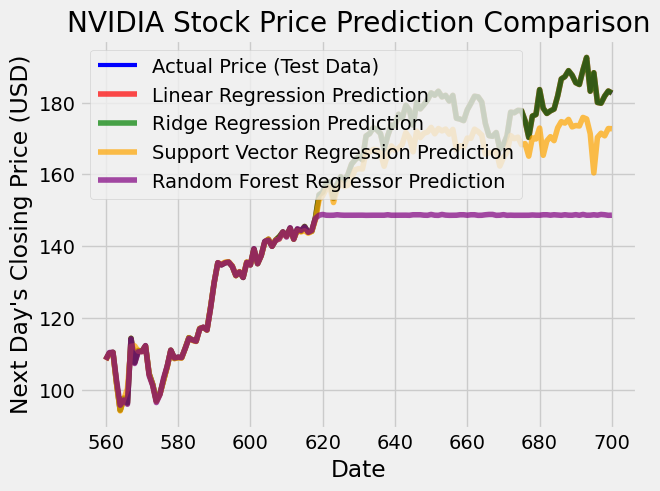

In [47]:
plt.Figure(figsize=(14,6))
plt.title("NVIDIA Stock Price Prediction Comparison")
plt.plot(df.index[-len(y_test):],y_test,label="Actual Price (Test Data)",color="blue",linewidth=3) # Actual Prices
colors = ["red","green","orange","purple"]

# Plot the predictions for all models
for i,name in enumerate(results.keys()):
    plt.plot(df.index[-len(y_test):],results[name]["y_pred"],label=f"{name} Prediction",alpha=0.7,color=colors[i])

plt.xlabel("Date")
plt.ylabel("Next Day's Closing Price (USD)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

New Prediction Input Function

In [48]:
def predict_new_price(current_close,yesterday_close,volatility,model_info):
    """
    Predicts the next day's closing price using the best model.
    :param current_close: Today's (last available) closing price.
    :param yesterday_close: The closing price from the day before that.
    :param volatility: Today's High - Low price difference.
    :param model_info: Dictionary containing the best model and scaler.
    """
    # Get the model and scaler from the results
    model = model_info["model"]
    scaler = model_info["scaler"]
    model_name = model_info["name"]

    # Create the new input data array (must match the feature order)
    new_data = np.array([[current_close,yesterday_close,volatility]])

    # Scale the new input data using the fitted training scaler
    new_data_scaled = scaler.transform(new_data)

    # Make the prediction
    predicted_price = model.predict(new_data_scaled)[0]

    print("----- New Price Prediction -----")
    print(f"Using Model: {model_name}")
    print(f"Input Features (Close,Lag_1,Volatility): {new_data[0]}")
    print(f"Predicted Next Day's Close Price: ${predicted_price:.2f}")


# Example Usage of the New prediction function (using the last point from the dataframe)
last_day_features = df.iloc[-1][features].values
# We use the features from the last recorded day to predict the price for the next unrecorded day
predict_new_price(
    current_close=last_day_features[0],
    yesterday_close=last_day_features[1],
    volatility=last_day_features[2],
    model_info=best_model
)

----- New Price Prediction -----
Using Model: Linear Regression
Input Features (Close,Lag_1,Volatility): [183.22000122 182.63999939   4.3500061 ]
Predicted Next Day's Close Price: $182.64
